In [1]:
!pip install torch torchdata
!pip install transformers datasets
!pip install -q -U bitsandbytes
!pip install -U accelerate
!pip install evaluate rouge_score
!pip install -qqq trl
!pip install loralib peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer,DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
from datasets import load_dataset, DatasetDict, load_metric
import accelerate

import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
seperator_print_short = '-'.join('' for x in range(100))
seperator_print_long = '-'.join('' for x in range(140))

def print_input_outputs(i, index, input, label, model_output):
    print(seperator_print_long)

    print(f"Sample {i+1}: Index = {index}")
    print(seperator_print_short)

    print(f"INPUT:")
    print(input)
    print(seperator_print_short)

    print("DATASET ORIGINAL LABEL:")
    print(label)
    print(seperator_print_short)

    if model_output != "":
        print("OUTPUT OF THE MODEL")
        print(model_output)
        print(seperator_print_short)

    print(seperator_print_long)



In [5]:
df = pd.read_csv('/content/drive/MyDrive/movies.csv')

df_cleaned = df.dropna(subset=['description'])
df_cleaned.to_csv('movies_cleaned.csv', index=False)



In [6]:
dataset_src = "movies_cleaned.csv"
dataset_origin = load_dataset('csv',
                       data_files=dataset_src
                       )
dataset_origin

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 780785
    })
})

In [7]:
dset_train_test = (load_dataset('csv',
                        data_files=dataset_src,
                        split='train'
                        )
          .train_test_split(train_size=0.7)
          )

dset_train_test

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 546549
    })
    test: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 234236
    })
})

In [8]:
dset_test_val = dset_train_test["test"].train_test_split(train_size=0.75)

dset_test_val

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 175677
    })
    test: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 58559
    })
})

In [9]:
dataset = DatasetDict({
                      'train': dset_train_test['train'],
                      'validation': dset_test_val['train'],
                      'test': dset_test_val['test']}
                      )

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 546549
    })
    validation: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 175677
    })
    test: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 58559
    })
})

In [10]:

dataset['train'] = dataset['train'].shuffle().select([i for i in range(6000)])
dataset['validation'] = dataset['validation'].shuffle().select([i for i in range(1000)])
dataset['test'] = dataset['test'].shuffle().select([i for i in range(250)])
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'],
        num_rows: 250
    })
})

In [11]:
INPUT_COL_NAME = "description"
OUTPUT_COL_NAME = "name"

In [12]:
 from transformers import BitsAndBytesConfig

 BNB_NF4_CONFIG = BitsAndBytesConfig(
     load_in_4bit=True,
     bnb_4bit_use_double_quant=True,
     bnb_4bit_quant_type="nf4",
     bnb_4bit_compute_dtype=torch.bfloat16
 )

In [13]:

model_id='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_id,
                                              quantization_config = BNB_NF4_CONFIG,
                                              device_map = "auto"
                                              )

tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          use_fast=True,
                                          )


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [14]:
LORA_R = 8
LORA_ALPHA = 64
LORA_DROPOUT = 0.01

lora_config=LoraConfig(
    r = LORA_R,
    lora_alpha = LORA_ALPHA,
    target_modules=["q", "v"],
    lora_dropout = LORA_DROPOUT,
    bias = "lora_only",
    task_type = TaskType.SEQ_2_SEQ_LM
)


peft_model=get_peft_model(model,lora_config)



In [15]:
def tokenize_function(example):
    START_prompt = 'Generate a relevant name related to the given description:'
    END_prompt = '\n\nGenerated name: '

    prompt = [START_prompt + abstract + END_prompt for abstract in example['description']]
    example['input_ids'] = tokenizer(prompt,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="pt").input_ids

    example['labels'] = tokenizer(example["name"],
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt").input_ids

    return example


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating'])

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [16]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 250
    })
})


In [17]:
output_model_name = "FlantT5"
output_config_option = "peftqlora"
output_task = "title-generation"


OUTPUT_DIR = f'./{output_model_name}-{output_config_option}-{output_task}'

In [18]:
peft_training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,
    num_train_epochs = 4,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2,
    learning_rate = 2e-4,
    optim = "paged_adamw_32bit" ,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",
    logging_steps = 4,
    metric_for_best_model = 'eval_loss'
)



model.config.use_cache = False

peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'],
    data_collator=DataCollatorForSeq2Seq(tokenizer),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
peft_trainer.train()


Epoch,Training Loss,Validation Loss
1,0.723400,0.655762
2,0.951600,0.656738
3,0.746300,0.655273
4,0.671600,0.659668


TrainOutput(global_step=3000, training_loss=1.165887410481771, metrics={'train_runtime': 2936.3679, 'train_samples_per_second': 8.173, 'train_steps_per_second': 1.022, 'total_flos': 1.301936353394688e+16, 'train_loss': 1.165887410481771, 'epoch': 4.0})

In [20]:
PATH_peft_model="./flanT5-lora-title-generator"

peft_trainer.model.save_pretrained(PATH_peft_model)
tokenizer.save_pretrained(PATH_peft_model)

('./flanT5-lora-title-generator/tokenizer_config.json',
 './flanT5-lora-title-generator/special_tokens_map.json',
 './flanT5-lora-title-generator/spiece.model',
 './flanT5-lora-title-generator/added_tokens.json',
 './flanT5-lora-title-generator/tokenizer.json')

In [21]:
peft_model = PeftModel.from_pretrained(model,
                                       PATH_peft_model,
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [37]:
TEST_INDEX = 24

description = dataset['test'][TEST_INDEX][INPUT_COL_NAME]
name = dataset['test'][TEST_INDEX][OUTPUT_COL_NAME]

prompt = f"""
Generate a name related to the given description:
{description}

Generated name:
"""
inputs = tokenizer(prompt, return_tensors='pt')

output_peft = tokenizer.decode(
    peft_model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperatue=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)



print(prompt)
print(seperator_print_short)

print('Label:')
print(name)
print(seperator_print_short)


print('PEFT Summary:')
print(output_peft)
print(seperator_print_short)




Generate a name related to the given description:
Led by pianist / singer Gary Brooker, this 1971 Beat Club Workshop showcases the band at the height of their career. The show features BJ Wilson on drums, Chris Chopping on organ, Dave Ball on guitar, Allan Cartwright on bass, and Gary Brooker on piano and vocals.  Superb musicianship and artistry come blazing through in these rare and exciting performances of artists and groups of the 60s, 70s, and 80s. These are the international stars that were part of the televised monthly music show Beat Club and MusikLaden. Filmed in Germany at the television studios of Radio Bremen, MusikLaden (originally known as Beat Club) became a TV classic not only for the fans, but also for the artists who took part. There was no time limitation on song length so artists were able to perform live concert versions of their most popular hit songs.

Generated name:

----------------------------------------------------------------------------------------------

In [23]:
metric = evaluate.load("rouge")

def get_decoded_pred_samples(sample, max_target_length=40):

    outputs = peft_model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                             max_new_tokens=max_target_length)

    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(),
                                  skip_special_tokens=True)

    labels = np.where(sample['labels'] != -100,
                      sample['labels'],
                      tokenizer.pad_token_id)


    labels = tokenizer.decode(labels, skip_special_tokens=True)
    return prediction, labels


In [24]:
test_dataset = tokenized_datasets['test'].with_format("torch")

df_list_elements = []

predictions, references = [] , []
for sample in tqdm(test_dataset):
    pred, y = get_decoded_pred_samples(sample)
    predictions.append(pred)
    references.append(y)

    df_list_elements.append([sample, y, pred])

100%|██████████| 250/250 [01:34<00:00,  2.65it/s]


In [25]:
for pred in predictions[:5]:
  print(pred)

Old Fashion
Pacific Buoy
The New Cinema
Summer of Reconciliation
The Recall


In [26]:
rogue = metric.compute(predictions=predictions,
                       references=references,
                       use_stemmer=True)

print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

Rogue1: 17.699990%
rouge2: 9.697359%
rougeL: 17.593003%
rougeLsum: 17.825179%


In [27]:
df_model_results = pd.DataFrame(df_list_elements,
                                columns=["sample", "label", "prediction"])

df_model_results = df_model_results.drop('sample', axis=1)

df_model_results.to_csv('results.csv')
df_model_results

,label,prediction
0,The Fourposter,Old Fashion
1,Detective Conan: Black Iron Submarine,Pacific Buoy
2,sunworshipper,The New Cinema
3,Bola de Fogo,Summer of Reconciliation
4,Dream Static,The Recall
...,...,...
245,Superbror,Superbrother
246,He,The New Year
247,Three Paths,Microfonture
248,Summer’s Choice,Teenage


In [28]:
df_trainer_logs = pd.DataFrame(peft_trainer.state.log_history)

df_trainer_logs

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,39.6992,48.507076,1.997333e-04,0.005333,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34.3633,23.794504,1.994667e-04,0.010667,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32.6035,20.777269,1.992000e-04,0.016000,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29.4551,20.832048,1.989333e-04,0.021333,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25.5000,21.336323,1.986667e-04,0.026667,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.8242,0.637891,5.333333e-07,3.989333,2992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,0.8546,0.856866,2.666667e-07,3.994667,2996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,0.6716,0.505976,0.000000e+00,4.000000,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,NaN,NaN,NaN,4.000000,3000,0.659668,54.42,18.376,2.297,NaN,NaN,NaN,NaN,NaN


In [29]:
df_trainer_logs.to_csv('train_logs.csv')

In [30]:
df_trainer_logs = df_trainer_logs[["epoch","loss","eval_loss","learning_rate","step"]]
df_trainer_logs

,epoch,loss,eval_loss,learning_rate,step
0,0.005333,39.6992,NaN,1.997333e-04,4
1,0.010667,34.3633,NaN,1.994667e-04,8
2,0.016000,32.6035,NaN,1.992000e-04,12
3,0.021333,29.4551,NaN,1.989333e-04,16
4,0.026667,25.5000,NaN,1.986667e-04,20
...,...,...,...,...,...
750,3.989333,0.8242,NaN,5.333333e-07,2992
751,3.994667,0.8546,NaN,2.666667e-07,2996
752,4.000000,0.6716,NaN,0.000000e+00,3000
753,4.000000,NaN,0.659668,NaN,3000


Text(0, 0.5, 'Loss')

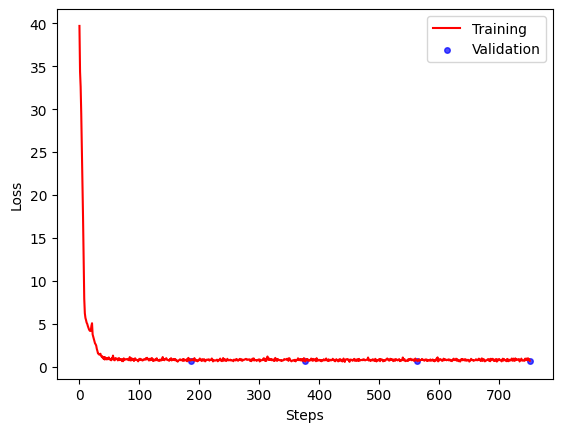

In [31]:
steps = df_trainer_logs.index
train_loss = df_trainer_logs.loss
eval_loss_list = df_trainer_logs.eval_loss

plt.plot(steps, train_loss, label="train_loss", color = "red")
plt.scatter(steps, eval_loss_list,
            c="blue", alpha=0.7, s=16)

plt.legend(["Training", "Validation"], loc ="upper right")
plt.xlabel("Steps")
plt.ylabel("Loss")